In [1]:
import numpy as np
import pylab as pl
import scipy.fftpack as ff
import h5py
import arrayfire as af

In [2]:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

### For reference
\begin{align}
\hat{V}(k) &= \int_{0}^{1} V(x)e^{-2\pi\;i\;k\;x}dx \\ \\
V(x) &= \frac{1}{Npoints}\int_{0}^{1} \hat{V}(k)e^{+2\pi\;i\;k\;x}dk \\ \\
\hat{V}(k) &= \frac{1}{4\pi^{2}\;k^2}\hat{\rho(k)} \\ \\
\hat{E}(k) &= -i(2\pi\;k)\hat{V}(k)
\end{align}

In [3]:
# FFT solver :
def fft_poisson(rho,dx):
    
    rho_p = rho[:-1]
    
    kspace = ff.fftfreq(len(rho_p), d = dx)
#     print('kspace[0]',kspace[0])
    rho_kspace = ff.fft(rho_p)

    V_kspace = np.zeros(len(rho_p))
    
    V_kspace[1:] =  (1/(4 * np.pi**2 * kspace[1:]**2)) * rho_kspace[1:]
    V_kspace[0]  =  0#(1/(4 * np.pi**2)) * np.sum(rho_p)/(len(rho_p)) 
#     print('rho_kspace[0] is ', rho_kspace[0])
    
    E_kspace =  -1j * 2 * np. pi * kspace * V_kspace
    
    V = ff.ifft(V_kspace)

    V = V.astype(np.double)
    
    E = ff.ifft(E_kspace)
    
    E = E.astype(np.double)
    
    E = np.append(E,E[0])
    V = np.append(V,V[0])
    
    return V, E

In [4]:
def convergence(N):
     
    error = np.zeros(len(N))
    
    for i in range(len(N)):
        rho_size = N[i]
        x = np.linspace(0, 1, rho_size )

        A = 0.5
        rho_0 = 0
        rho =  rho_0 + A * np.cos(2 * np.pi * x)
        dx = x[1] - x[0]

        V, E = fft_poisson(rho, dx)
        
        E = af.to_array(E)
        
        number_random_points = 1000

        x_random = (af.randu(number_random_points)).as_type(af.Dtype.f64)
        
#         print(x_random)
#         dx = af.sum(dx)
        
        
        
        frac_x_random = ((x_random)/dx)*(rho_size - 1)
        
        E_random = af.signal.approx1(E, frac_x_random)
        
        E_random = np.array(E_random)
        error[i] = np.sum(np.abs(E_random - A * np.sin(2 * np.pi * x_random)/(2 * np.pi))) / rho_size
        
        
    return error

In [5]:
N = np.array([32, 64, 128, 256, 512, 1024])

error = convergence(N)

/home/tejas/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
/home/tejas/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/home/tejas/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


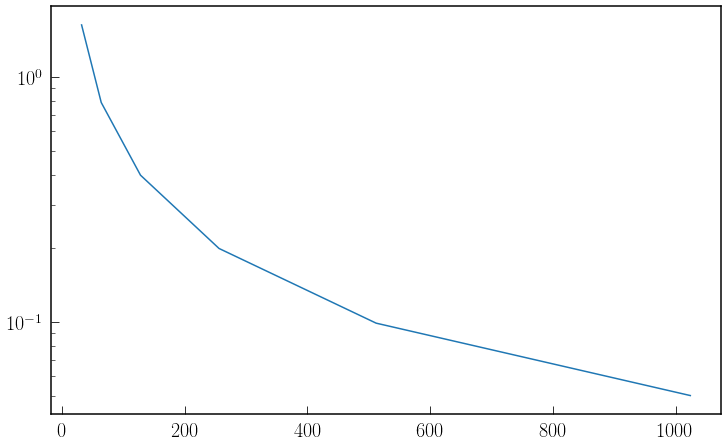

In [7]:
pl.semilogy(N, error, label = r'$\mathrm{L_{1}\l norm\;of\;error}$')
pl.show()
pl.clf()

In [ ]:
pl.plot(x_random, E_random)
pl.show()
pl.clf()